In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("C:\\Program Files\\DIgSILENT\\PowerFactory 2024 SP4A\\Python\\3.12")
import powerfactory as pf

PFapp: pf.Application = pf.GetApplicationExt()
PFapp.Show()

from admittance_matrix.utils import init_project
init_project(PFapp, "Lokalizacija\\11_bus_radial_system")

True

In [49]:
from admittance_matrix import Network

# Initialize network from PowerFactory
net = Network(PFapp, base_mva=100.0)

print(f"Network Summary:")
print(f"  Buses: {net.n_buses}")
print(f"  Generators: {net.n_generators}")
print(f"  Loads: {net.n_loads}")
print(f"  Lines: {net.n_lines}")
print(f"  Transformers: {net.n_transformers}")

Network Summary:
  Buses: 39
  Generators: 10
  Loads: 19
  Lines: 34
  Transformers: 12


In [50]:
DIST_GEN = "G 08"  # <-- Enter generator name here

# Build matrices, run load flow, and reduce to generators in one workflow
net.build_matrices() # Obtain LoadFlow admittance matrix and Stability admittance matrix

In [51]:
import pandas as pd

# # Display the stability admittance matrix
# print("=== STABILITY Y-MATRIX (network + loads) ===")
# display(pd.DataFrame(net.Y_stab, index=net.bus_names, columns=net.bus_names))

In [52]:
# Now apply code to calculate synchronizing power coefficients and power distribution ratios
net.run_load_flow()
net.reduce_to_generators()

# Calculate power distribution ratios (returns ratios and matching gen names)
ratios, gen_names_order = net.calculate_power_ratios(DIST_GEN)

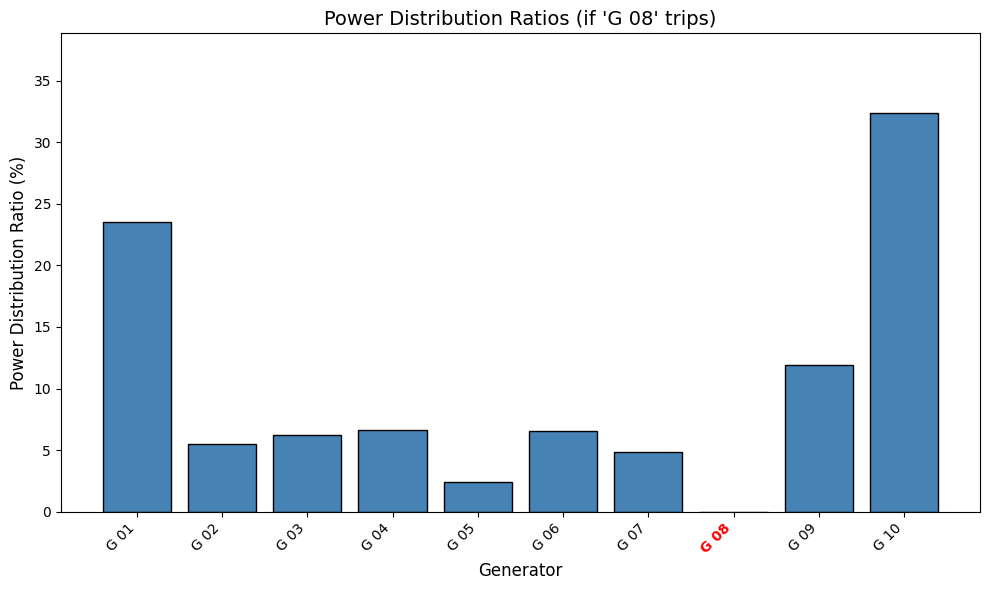

In [53]:
import matplotlib.pyplot as plt

# Create bar chart of power distribution ratios
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(gen_names_order, ratios * 100, color='steelblue', edgecolor='black')

ax.set_xlabel('Generator', fontsize=12)
ax.set_ylabel('Power Distribution Ratio (%)', fontsize=12)
ax.set_title(f"Power Distribution Ratios (if '{DIST_GEN}' trips)", fontsize=14)
ax.set_ylim(0, max(ratios * 100) * 1.2 if max(ratios) > 0 else 10)

# Color the tripped generator label in red
plt.xticks(rotation=45, ha='right')
for label in ax.get_xticklabels():
    if label.get_text() == DIST_GEN:
        label.set_color('red')
        label.set_fontweight('bold')

plt.tight_layout()
plt.show()

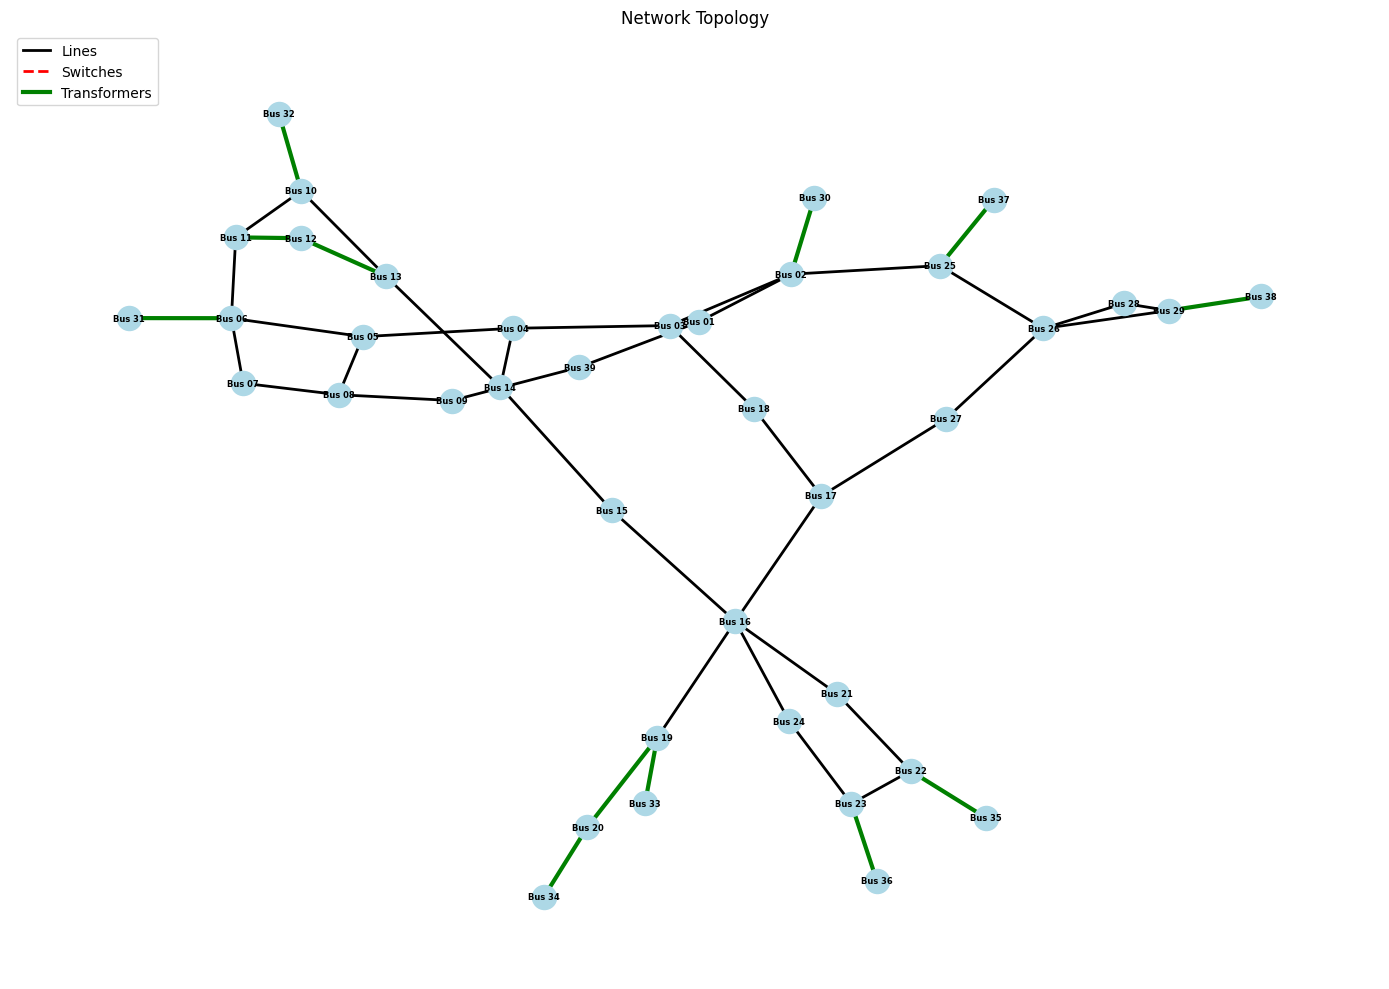

In [54]:
import matplotlib.pyplot as plt
import networkx as nx

# Create graph from branches
G = nx.Graph()

# Add nodes (buses)
for bus in net.bus_names:
    G.add_node(bus)

# Add edges (branches) with impedance labels
for b in net.branches:
    z = b.impedance
    if z.real != float('inf'):
        z_label = f"{z.real:.2f}+j{z.imag:.2f}"
    else:
        z_label = "open"
    G.add_edge(b.from_bus_name, b.to_bus_name, label=b.name, branch_type=type(b).__name__)

# Draw the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold')

# Draw edges with different colors for lines, switches, and transformers
line_edges = [(u, v) for u, v, d in G.edges(data=True) if d['branch_type'] == 'LineBranch']
switch_edges = [(u, v) for u, v, d in G.edges(data=True) if d['branch_type'] == 'SwitchBranch']
trafo_edges = [(u, v) for u, v, d in G.edges(data=True) if d['branch_type'] == 'TransformerBranch']

nx.draw_networkx_edges(G, pos, edgelist=line_edges, edge_color='black', width=2)
nx.draw_networkx_edges(G, pos, edgelist=switch_edges, edge_color='red', width=2, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=trafo_edges, edge_color='green', width=3)

# Add legend
plt.plot([], [], color='black', linewidth=2, label='Lines')
plt.plot([], [], color='red', linewidth=2, linestyle='dashed', label='Switches')
plt.plot([], [], color='green', linewidth=3, label='Transformers')
plt.legend(loc='upper left')

plt.title("Network Topology")
plt.axis('off')
plt.tight_layout()
plt.show()